# Get "unknown block" addresses

Apart from the 64 bit (8 byte) configuration block headers (the ones with 16-bit Modbus CRC), there are also addition 1344 bit (168 byte) long blocks in the bitstream. I am calling those blocks "unknown blocks" - it seems that they are not important for pin configuration.

In [1]:
import zipfile
import os
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

from JicBitstream import JicBitstream, JicBitstreamZip
from knowledge import PU_ADDR
from knowledge2 import BLK_LOC_START_BIT

%matplotlib notebook

In [2]:
def compare(lst, fn0, fn1, path="../../results/out_8BC/", verbose=False):
    if verbose:
        print(f"comparing {os.path.basename(fn0)} and {os.path.basename(fn1)}")
    fn0 = os.path.join(path, fn0)
    fn1 = os.path.join(path, fn1)
    jic0 = JicBitstreamZip(fn0)
    jic1 = JicBitstreamZip(fn1)
    diff = jic0.diff_pos(jic1)
    if verbose:
        print(diff)
    lst.append(diff)

In [3]:
def is_checksum_blk(addr):
    diff = BLK_LOC_START_BIT - addr
    lo = 1 <= diff 
    hi = diff <= 16
    comb = lo * hi
    ret = np.any(comb)
    return ret

In [4]:
def offs_cor(addr):
    return addr - (np.sum(addr > BLK_LOC_START_BIT) * 64)

In [5]:
pin_list = open("../../resources/pin_list_5SGSMD5K1F40C1_8BC.txt", "r").readlines()
pin_list = [pin.strip() for pin in pin_list]

In [6]:
IOSTD_ADDR = {}

UNKNW_BLK_LOWER_LIM = {}
UNKNW_BLK_UPPER_LIM = {}
UNKWN_BLK_NR = {}

In [7]:
for pin in pin_list:
    print("\n", pin)
    diff_lst = []

    # IO std diff
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_default.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_class1_default.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_class2_default.zip")
    
    diff_lst_comb = []

    for diff in diff_lst:
        for el in diff[0]:
            if not is_checksum_blk(el):
                diff_lst_comb.append(offs_cor(el))

    diff_lst_comb = np.array(sorted(list(set(diff_lst_comb))))
    X = diff_lst_comb.reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, random_state=123).fit(X)
    print("K-means cluster centers", kmeans.cluster_centers_.reshape(-1))

    APPROX_PIN_LOC = int(1e6)
    PIN_GROUP = kmeans.predict(np.array([APPROX_PIN_LOC]).reshape(1, -1))
    feat_addrs = X[kmeans.labels_ == PIN_GROUP].reshape((-1))
    

    rel_to_pu = feat_addrs - offs_cor(PU_ADDR[pin])
    print(feat_addrs)
    print(rel_to_pu)
    idx544 = np.where(rel_to_pu == 544)[0][0]
    print(rel_to_pu[idx544], rel_to_pu[idx544+1], (rel_to_pu[idx544+1] - 1504) / 1344)
    
    UNKNW_BLK_LOWER_LIM[pin] = feat_addrs[idx544]
    UNKNW_BLK_UPPER_LIM[pin] = feat_addrs[idx544+1]
    UNKWN_BLK_NR[pin] = (rel_to_pu[idx544+1] - 1504) // 1344

    print(feat_addrs[idx544-8:idx544+3])
    IOSTD_ADDR[pin] = feat_addrs[idx544-5:idx544+3]


 P25
K-means cluster centers [1.15835100e+06 2.68427613e+08 3.65800000e+03]
[1096583 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543
 1158319 1158351 1158383 1158415 1158447 1158479 1158511 1158575 1158607
 1158671 1158703 1158735 1158767 1159375 1164367 1164399 1164463]
[-62248 -61992 -61832 -54248 -53928 -53896 -53736 -53448 -53288   -512
   -480   -448   -416   -384   -352   -320   -256   -224   -160   -128
    -96    -64    544   5536   5568   5632]
544 5536 3.0
[1158479 1158511 1158575 1158607 1158671 1158703 1158735 1158767 1159375
 1164367 1164399]

 N25
K-means cluster centers [3.66200000e+03 2.68427614e+08 1.16238300e+06]
[1096583 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543
 1162351 1162383 1162415 1162447 1162479 1162511 1162543 1162607 1162639
 1162703 1162735 1162767 1162799 1163407 1164367 1164399 1164463]
[-66280 -66024 -65864 -58280 -57960 -57928 -57768 -57480 -57320   -512
   -480   -448   -416   -384   -352   -320   -256   -224   -1

K-means cluster centers [3.65900000e+03 2.68427618e+08 1.03230300e+06]
[1028847 1028879 1028911 1028943 1028975 1029007 1029039 1029103 1029135
 1029199 1029231 1029263 1029295 1029903 1032207 1032239 1032303 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[ -512  -480  -448  -416  -384  -352  -320  -256  -224  -160  -128   -96
   -64   544  2848  2880  2944 67224 67480 67640 75224 75544 75576 75736
 76024 76184]
544 2848 1.0
[1029007 1029039 1029103 1029135 1029199 1029231 1029263 1029295 1029903
 1032207 1032239]

 E24
K-means cluster centers [9.75119000e+05 2.68427614e+08 3.65800000e+03]
[ 974703  974735  974767  974799  974831  974863  974895  974959  974991
  975055  975087  975119  975151  975759  980751  980783  980847 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   5536   5568   5632 121368 121624 121784
 129368 129688 129720 

K-means cluster centers [3.66300000e+03 2.68427619e+08 8.46863000e+05]
[ 842127  842159  842191  842223  842255  842287  842319  842383  842415
  842479  842511  842543  842575  843183  846831  846863  846927 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   4192   4224   4288 253944 254200 254360
 261944 262264 262296 262456 262744 262904]
544 4192 2.0
[842287 842319 842383 842415 842479 842511 842543 842575 843183 846831
 846863]

 P28
K-means cluster centers [2.83900000e+03 2.68427618e+08 8.43919000e+05]
[ 843471  843503  843535  843567  843599  843631  843663  843727  843759
  843823  843855  843887  843919  844527  846831  846863  846927 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   2848   2880   2944 252600 252856 253016
 260600

K-means cluster centers [2.83900000e+03 2.68427617e+08 6.85455000e+05]
[ 683407  683439  683471  683503  683535  683567  683599  683663  683695
  683759  683791  683823  683855  684463  685423  685455  685519 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   1504   1536   1600 412664 412920 413080
 420664 420984 421016 421176 421464 421624]
544 1504 0.0
[683567 683599 683663 683695 683759 683791 683823 683855 684463 685423
 685455]

 C26
K-means cluster centers [2.80700000e+03 2.68427617e+08 6.85455000e+05]
[ 680719  680751  680783  680815  680847  680879  680911  680975  681007
  681071  681103  681135  681167  681775  685423  685455  685519 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   4192   4224   4288 415352 415608 415768
 423352

K-means cluster centers [3.6630000e+03 2.6842762e+08 1.0272140e+06]
[1026158 1026190 1026222 1026254 1026286 1026318 1026350 1026414 1026446
 1026510 1026542 1026574 1026606 1027214 1032206 1032238 1032302 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[ -512  -480  -448  -416  -384  -352  -320  -256  -224  -160  -128   -96
   -64   544  5536  5568  5632 69913 70169 70329 77913 78233 78265 78425
 78713 78873]
544 5536 3.0
[1026318 1026350 1026414 1026446 1026510 1026542 1026574 1026606 1027214
 1032206 1032238]

 E28
K-means cluster centers [3.65900000e+03 2.68427617e+08 1.03230200e+06]
[1030190 1030222 1030254 1030286 1030318 1030350 1030382 1030446 1030478
 1030542 1030574 1030606 1030638 1031246 1032206 1032238 1032302 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[ -512  -480  -448  -416  -384  -352  -320  -256  -224  -160  -128   -96
   -64   544  1504  1536  1600 65881 66137 66297 73881 74201 74233 74393
 74681 74841]
544 150

K-means cluster centers [2.83900000e+03 2.68427619e+08 8.95342000e+05]
[ 894926  894958  894990  895022  895054  895086  895118  895182  895214
  895278  895310  895342  895374  895982  898286  898318  898382 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   2848   2880   2944 201145 201401 201561
 209145 209465 209497 209657 209945 210105]
544 2848 1.0
[895086 895118 895182 895214 895278 895310 895342 895374 895982 898286
 898318]

 P31
K-means cluster centers [2.80700000e+03 2.68427618e+08 8.41230000e+05]
[ 840782  840814  840846  840878  840910  840942  840974  841038  841070
  841134  841166  841198  841230  841838  846830  846862  846926 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   5536   5568   5632 255289 255545 255705
 263289

K-means cluster centers [3.66200000e+03 2.68427614e+08 7.14702000e+05]
[ 709966  709998  710030  710062  710094  710126  710158  710222  710254
  710318  710350  710382  710414  711022  714670  714702  714766 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   4192   4224   4288 386105 386361 386521
 394105 394425 394457 394617 394905 395065]
544 4192 2.0
[710126 710158 710222 710254 710318 710350 710382 710414 711022 714670
 714702]

 F30
K-means cluster centers [3.66300000e+03 2.68427614e+08 7.14702000e+05]
[ 711310  711342  711374  711406  711438  711470  711502  711566  711598
  711662  711694  711726  711758  712366  714670  714702  714766 1096583
 1096839 1096999 1104583 1104903 1104935 1105095 1105383 1105543]
[  -512   -480   -448   -416   -384   -352   -320   -256   -224   -160
   -128    -96    -64    544   2848   2880   2944 384761 385017 385177
 392761

<IPython.core.display.Javascript object>


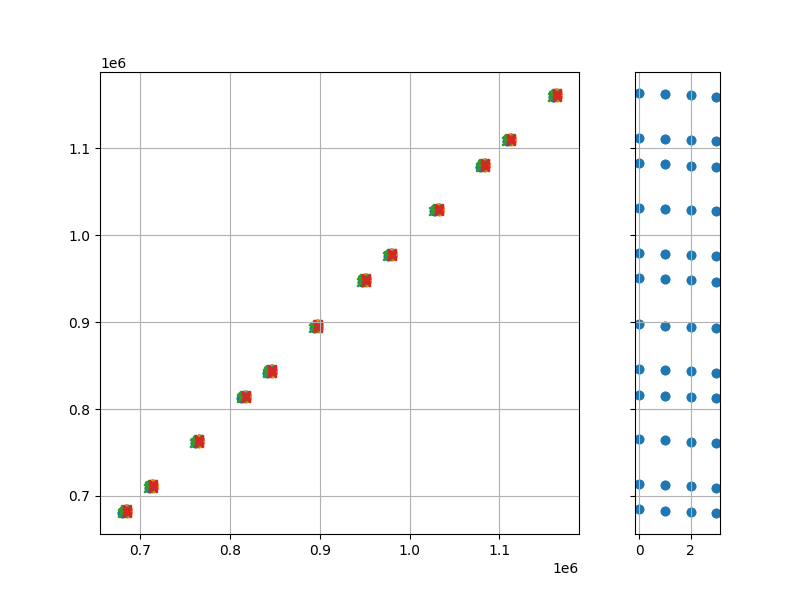

In [8]:
UNKNW_BLK_LOWER_LIM = dict(
    sorted(UNKNW_BLK_LOWER_LIM.items(), key=lambda item: item[1])
)
UNKNW_BLK_UPPER_LIM = dict(
    sorted(UNKNW_BLK_UPPER_LIM.items(), key=lambda item: item[1])
)

fig = plt.figure(figsize=(8, 6))
ax, ax2 = fig.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [0.85, 0.15]})

ax.scatter(UNKNW_BLK_LOWER_LIM.values(), UNKNW_BLK_LOWER_LIM.values())
ax.scatter(UNKNW_BLK_UPPER_LIM.values(), UNKNW_BLK_LOWER_LIM.values())
ax.scatter(
    [IOSTD_ADDR[a][0] for a in UNKNW_BLK_LOWER_LIM],
    UNKNW_BLK_LOWER_LIM.values(),
    marker='x'
)
ax.scatter(
    [IOSTD_ADDR[a][-1] for a in UNKNW_BLK_LOWER_LIM],
    UNKNW_BLK_LOWER_LIM.values(),
    marker='x'
)
ax.grid(True)

ax2.scatter(
    [UNKWN_BLK_NR[a] for a in UNKNW_BLK_LOWER_LIM], UNKNW_BLK_LOWER_LIM.values()
)
ax2.grid(True)

In [9]:
print("UNKWN_BLK_NR =", UNKWN_BLK_NR)
print("UNKNW_BLK_LOWER_LIM =", UNKNW_BLK_LOWER_LIM)

UNKWN_BLK_NR = {'P25': 3, 'N25': 0, 'U25': 2, 'T25': 1, 'R25': 3, 'R26': 0, 'P26': 2, 'N26': 1, 'M26': 3, 'L26': 0, 'K25': 2, 'J25': 1, 'G24': 3, 'F24': 0, 'H25': 2, 'G25': 1, 'E24': 3, 'E25': 0, 'D24': 2, 'C24': 1, 'D25': 3, 'C25': 0, 'B25': 2, 'A25': 1, 'U26': 3, 'U27': 0, 'T27': 2, 'R27': 1, 'U28': 3, 'T28': 0, 'N27': 2, 'P28': 1, 'K27': 3, 'J27': 0, 'M27': 2, 'L27': 1, 'G26': 3, 'F26': 0, 'J26': 2, 'H26': 1, 'G27': 3, 'F27': 0, 'E27': 2, 'D27': 1, 'B26': 3, 'A26': 0, 'C26': 2, 'C27': 1, 'V29': 3, 'U29': 0, 'R29': 2, 'P29': 1, 'U30': 3, 'T30': 0, 'N28': 2, 'M29': 1, 'J29': 3, 'J28': 0, 'L28': 2, 'K28': 1, 'F29': 3, 'E28': 0, 'H28': 2, 'G28': 1, 'H29': 3, 'G29': 0, 'D28': 2, 'C28': 1, 'B28': 3, 'A28': 0, 'B29': 2, 'A29': 1, 'N30': 3, 'M30': 0, 'R30': 2, 'R31': 1, 'P31': 3, 'N31': 0, 'L31': 2, 'L30': 1, 'K30': 3, 'J30': 0, 'K31': 2, 'J31': 1, 'B31': 3, 'A31': 0, 'D30': 2, 'C30': 1, 'D31': 3, 'C31': 0, 'G30': 2, 'F30': 1, 'E30': 3, 'E31': 0, 'H31': 2, 'G31': 1}
UNKNW_BLK_LOWER_LIM = {'